In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [49]:
plt.rcParams['figure.dpi'] = 300

# Survey Interpretation

Imputes measured depth (MD) and angle from csv data and populates approximate wellbore geometry.

Assumes efficient vertical section (no "corkscrew" in well trajectory).

In [35]:
svy = pd.read_csv('fake_survey.csv')

svy['incrDepth'] = svy['MD'] - svy['MD'].shift().fillna(0)
svy['av_angle'] = (svy['Angle'] + svy['Angle'].shift().fillna(0))/2
svy['cos_theta'] = np.cos(svy['av_angle'] * np.pi / 180)
svy['sin_theta'] = np.sin(svy['av_angle'] * np.pi / 180)
svy['incr_tvd'] = svy['cos_theta'] * svy['incrDepth']
svy['incr_vs'] = svy['sin_theta'] * svy['incrDepth']
svy['TVD'] = svy['incr_tvd'].cumsum()
svy['VS'] = svy['incr_vs'].cumsum()

svy

,MD,Angle,incrDepth,av_angle,cos_theta,sin_theta,incr_tvd,incr_vs,TVD,VS
0,0,0,0.0,0.0,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,5000,0,5000.0,0.0,1.000000e+00,0.000000,5.000000e+03,0.000000,5000.000000,0.000000
2,5100,12,100.0,6.0,9.945219e-01,0.104528,9.945219e+01,10.452846,5099.452190,10.452846
3,5200,24,100.0,18.0,9.510565e-01,0.309017,9.510565e+01,30.901699,5194.557841,41.354546
4,5300,36,100.0,30.0,8.660254e-01,0.500000,8.660254e+01,50.000000,5281.160382,91.354546
5,5400,48,100.0,42.0,7.431448e-01,0.669131,7.431448e+01,66.913061,5355.474864,158.267606
6,5500,60,100.0,54.0,5.877853e-01,0.809017,5.877853e+01,80.901699,5414.253389,239.169306
7,5600,72,100.0,66.0,4.067366e-01,0.913545,4.067366e+01,91.354546,5454.927054,330.523852
8,5700,84,100.0,78.0,2.079117e-01,0.978148,2.079117e+01,97.814760,5475.718223,428.338612
9,5800,90,100.0,87.0,5.233596e-02,0.998630,5.233596e+00,99.862953,5480.951818,528.201565


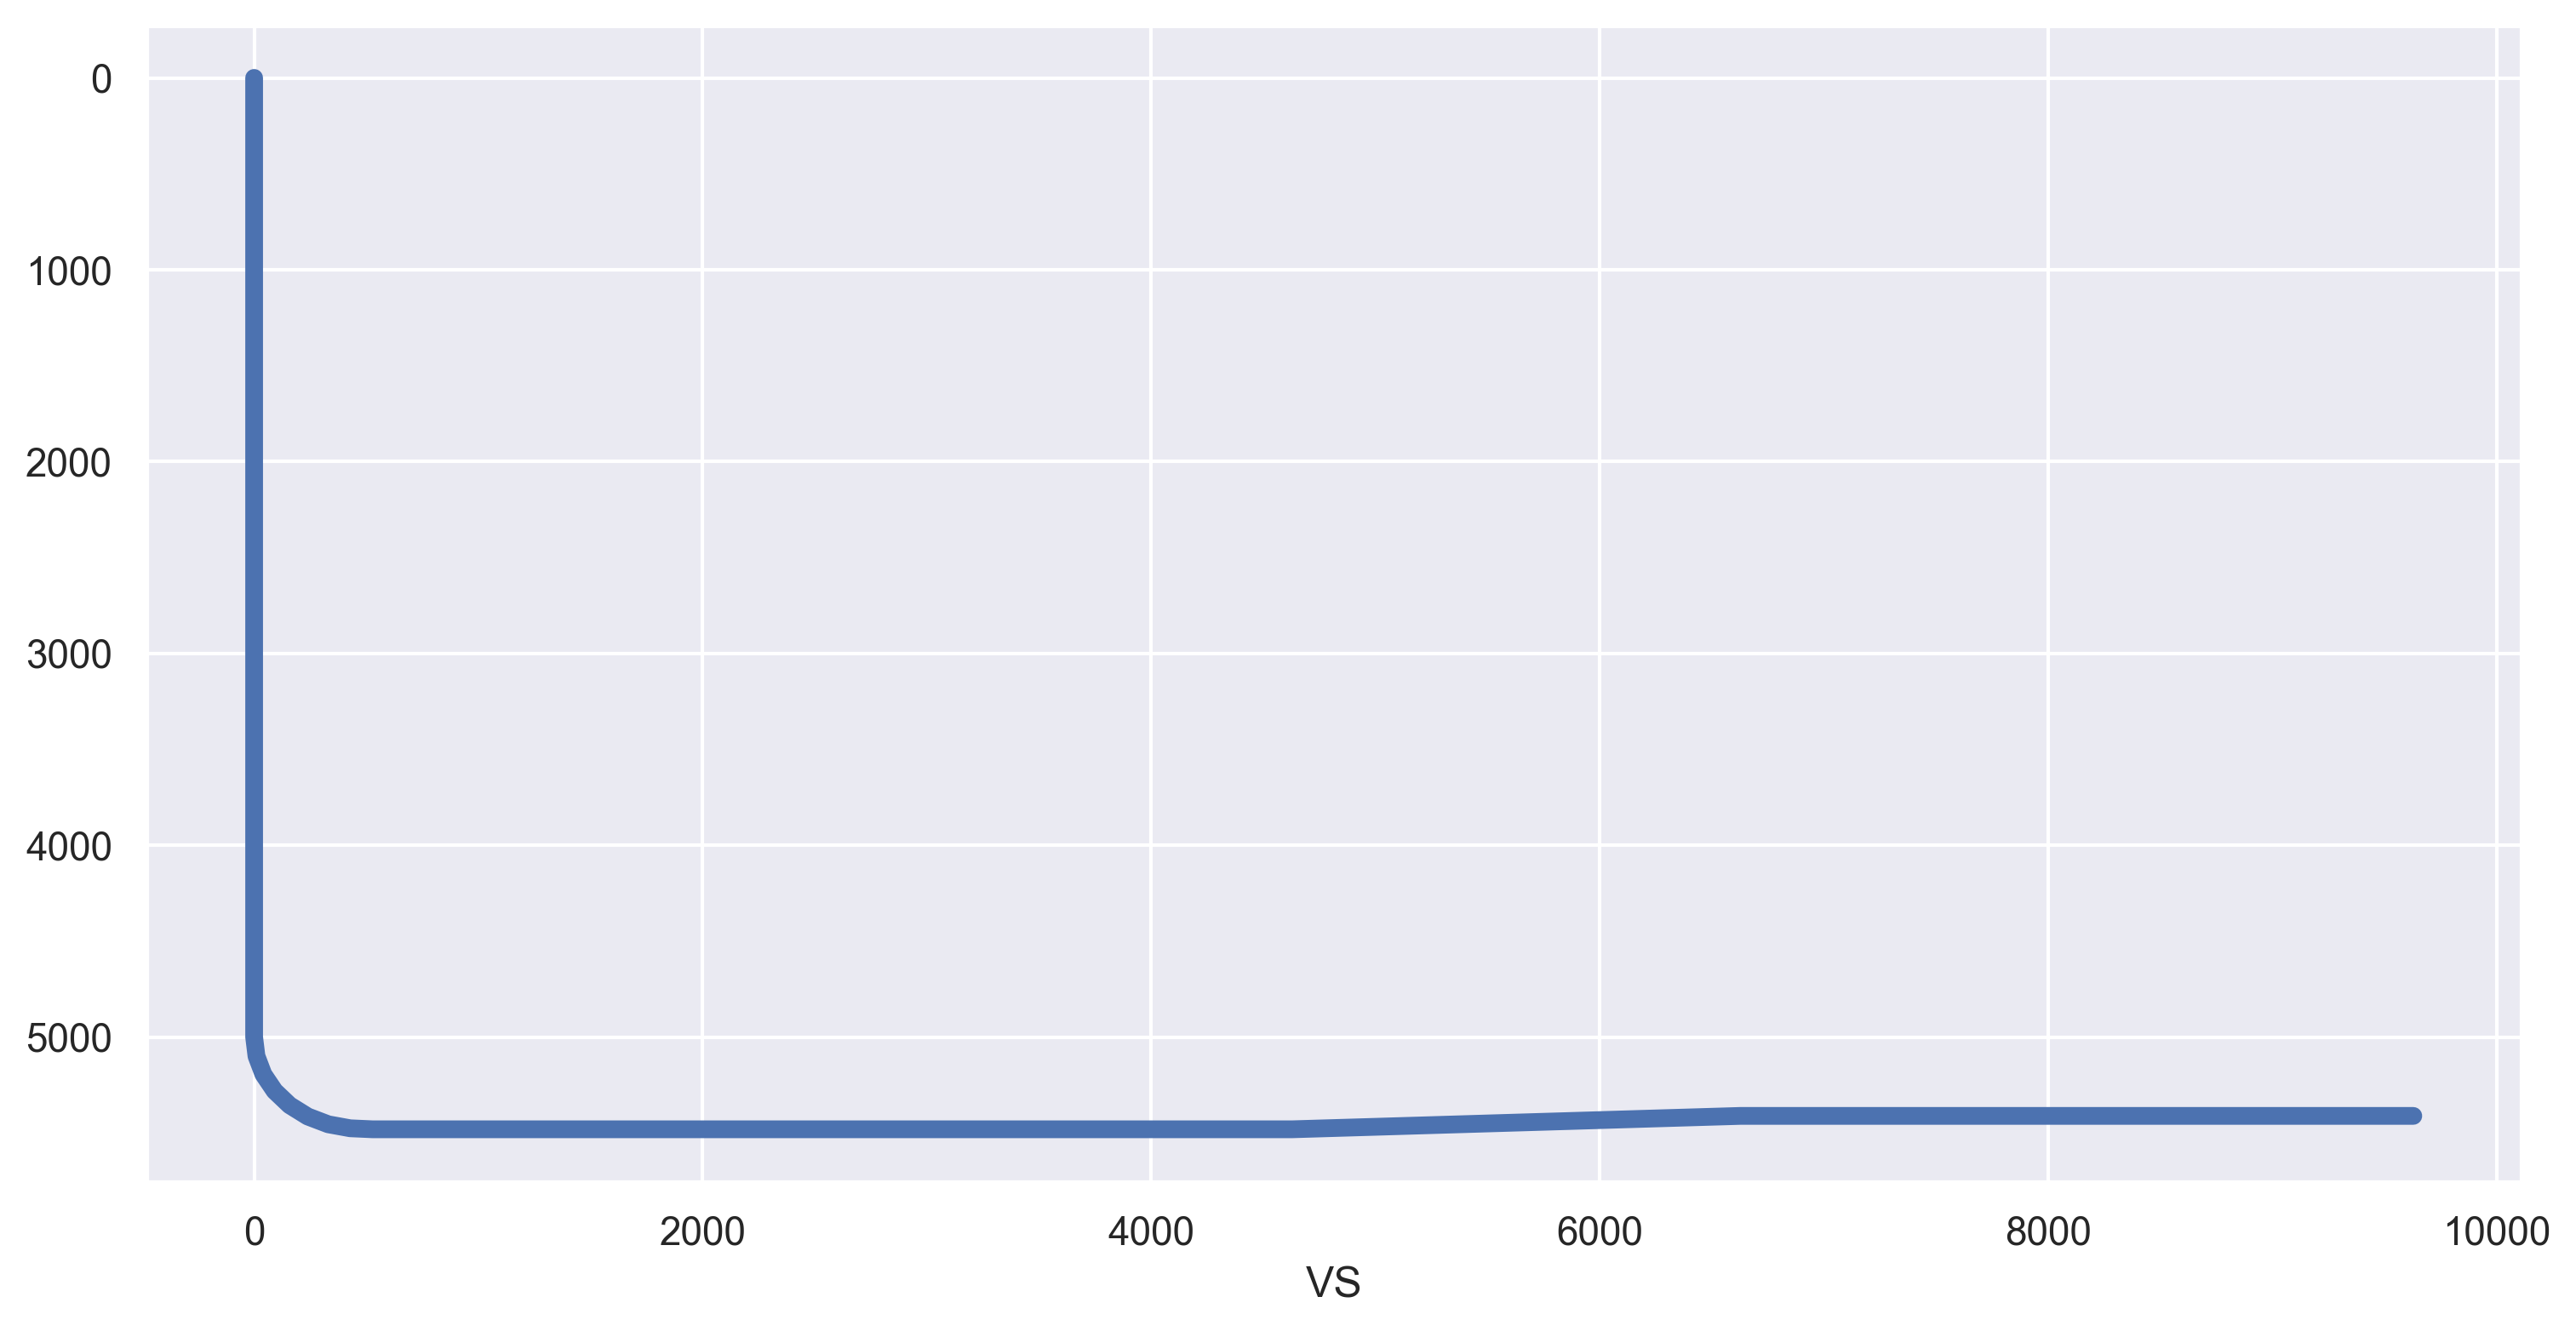

In [50]:
svy.plot(x='VS', y='TVD', figsize=(12,6), lw=5, legend=False).invert_yaxis();

# Wellbore Modeling

In [37]:
wb = pd.read_csv('fake_wellbore.csv')
wb

,wb_section,md_top,md_bottom,ID,OD,Roughness
0,tubing,0,5800,0,2.441,0.000006
1,casing,5800,11092,0,2.441,0.000006
2,restriction,11092,11103,0,2.200,0.000006
3,casing,11103,14857,0,4.778,0.000006


#### Break the wellbore into 10-ft segments:

In [38]:
max_md = wb.md_bottom.max()

bins = (np.ceil(max_md / 10) + int(max_md % 10 != 0)).astype(int)
bins

1487

In [39]:
df = pd.DataFrame(index=range(bins))
df['md_top'] = df.index * 10
df.loc[df['md_top'] > max_md, 'md_top'] = max_md
df

,md_top
0,0
1,10
2,20
3,30
4,40
...,...
1482,14820
1483,14830
1484,14840
1485,14850


In [40]:
wbdf = df.merge(wb, on='md_top', how='outer')
wbdf = wbdf.sort_values('md_top').reset_index(drop=True)
wbdf = wbdf.ffill()
wbdf

,md_top,wb_section,md_bottom,ID,OD,Roughness
0,0,tubing,5800.0,0.0,2.441,0.000006
1,10,tubing,5800.0,0.0,2.441,0.000006
2,20,tubing,5800.0,0.0,2.441,0.000006
3,30,tubing,5800.0,0.0,2.441,0.000006
4,40,tubing,5800.0,0.0,2.441,0.000006
...,...,...,...,...,...,...
1484,14820,casing,14857.0,0.0,4.778,0.000006
1485,14830,casing,14857.0,0.0,4.778,0.000006
1486,14840,casing,14857.0,0.0,4.778,0.000006
1487,14850,casing,14857.0,0.0,4.778,0.000006


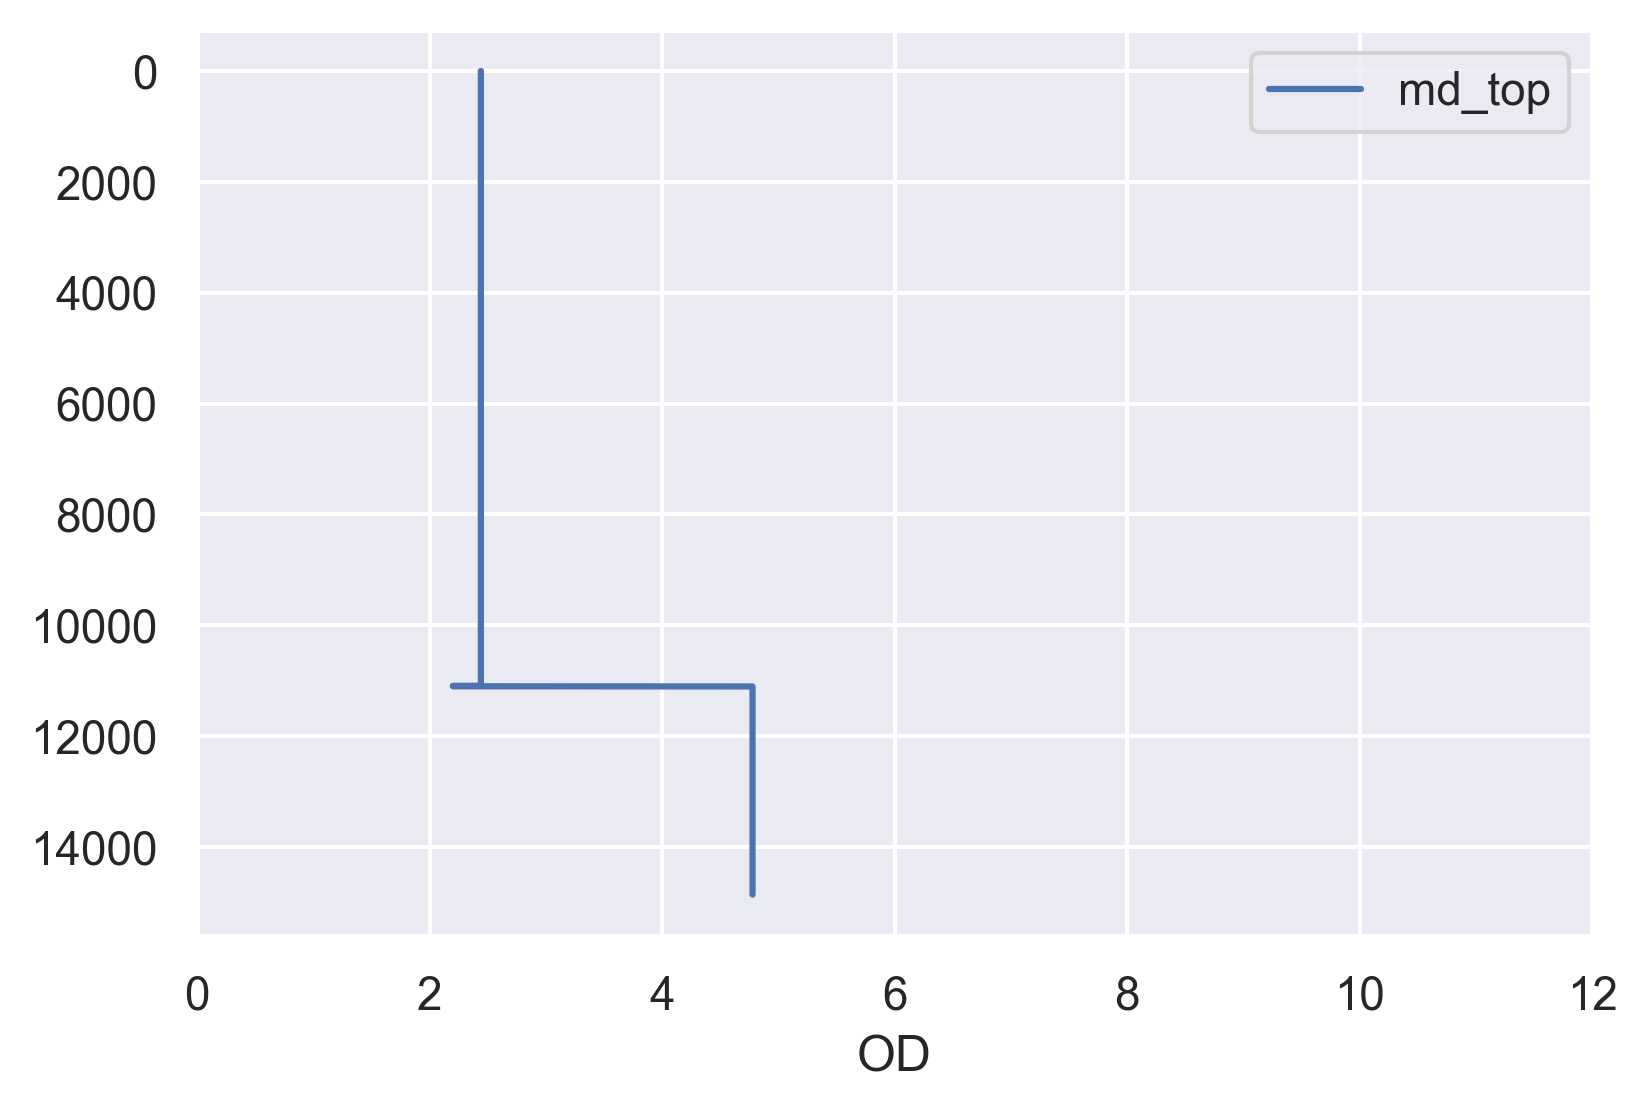

In [51]:
wbdf.plot(x='OD', y='md_top', xlim=(0,12)).invert_yaxis()

In [42]:
# wbdf.to_excel('test_wb.xlsx')

# Pipe Flow - Pressure Loss

link for working on pressure loss:
https://www.ihsenergy.ca/support/documentation_ca/Harmony/content/html_files/reference_material/calculations_and_correlations/pressure_loss_calculations.htm

## Friction Loss

In [43]:
def re_num(dens, vel, ID, visc):
    '''
    ...
    This function imputes liquid density, velocity, flow area (diameter),
    and viscosity and returns a Reynolds number.
    ...
    
    Arguments
    --------
    dens : fluid density,           lb/cuft
    vel  : flow velocity,           ft/sec
    ID   : diameter of flow area,   ft
    visc : fluid viscosity,         cp
    ...
    '''
    
    Re = 1488 * dens * vel * ID / visc
    return Re

In [44]:
# test the re_num function:

dens = 62.4
visc = 1
ID = 2.441 / 12
vel = 3

re_num(dens, vel, ID, visc)

56662.4448

In [45]:
def fanning_f(Re, abs_roughness, ID):
    '''
    ...
    This function imputes Reynolds number (Re), absolute roughness, and
    flow area diameter (ID), and returns the Fanning Friction Factor (f).
    ...
    
    Arguments:
    --------
    Re            : Reynolds number,                     dimensionless
    abs_roughness : Absolute Roughness, assumed 150e-6,  feet
    ID            : diameter of flow area,               feet
    ...
    
    '''
    
    f_lam = 16 / Re
    inv_sqrt_f = -4 * np.log10(0.2698 * (abs_roughness / ID) - (5.0452 / Re) * np.log10(.3539 * (abs_roughness / ID)**1.1098 + 5.8506 / Re**.8981))
    f_turb = (1 / inv_sqrt_f)**2
    
    if(Re <= 2000):
        f = f_lam
    elif((Re > 2000) & (Re < 4000)):
        f = (f_lam * (4000 - Re) + f_turb * (Re - 2000)) / 2000
    elif(Re >= 4000):
        f = f_turb
        
    return f

In [46]:
# test the fanning_f function:

fanning_f(2000, .00006, 5e-2/.00006)

0.008

In [47]:
df = pd.DataFrame({'vel': np.arange(0.001,2000,.01)})
df['Re'] = df.apply(lambda x: re_num(dens, df['vel'], ID, visc), axis=0)
df['f'] = df.apply(lambda x: fanning_f(x['Re'], 150e-6, 150e-6/5e-2), axis=1)

df

,vel,Re,f
0,0.001,1.888748e+01,0.847122
1,0.011,2.077623e+02,0.077011
2,0.021,3.966371e+02,0.040339
3,0.031,5.855119e+02,0.027327
4,0.041,7.743867e+02,0.020662
...,...,...,...
199995,1999.951,3.777404e+07,0.017873
199996,1999.961,3.777423e+07,0.017873
199997,1999.971,3.777442e+07,0.017873
199998,1999.981,3.777460e+07,0.017873


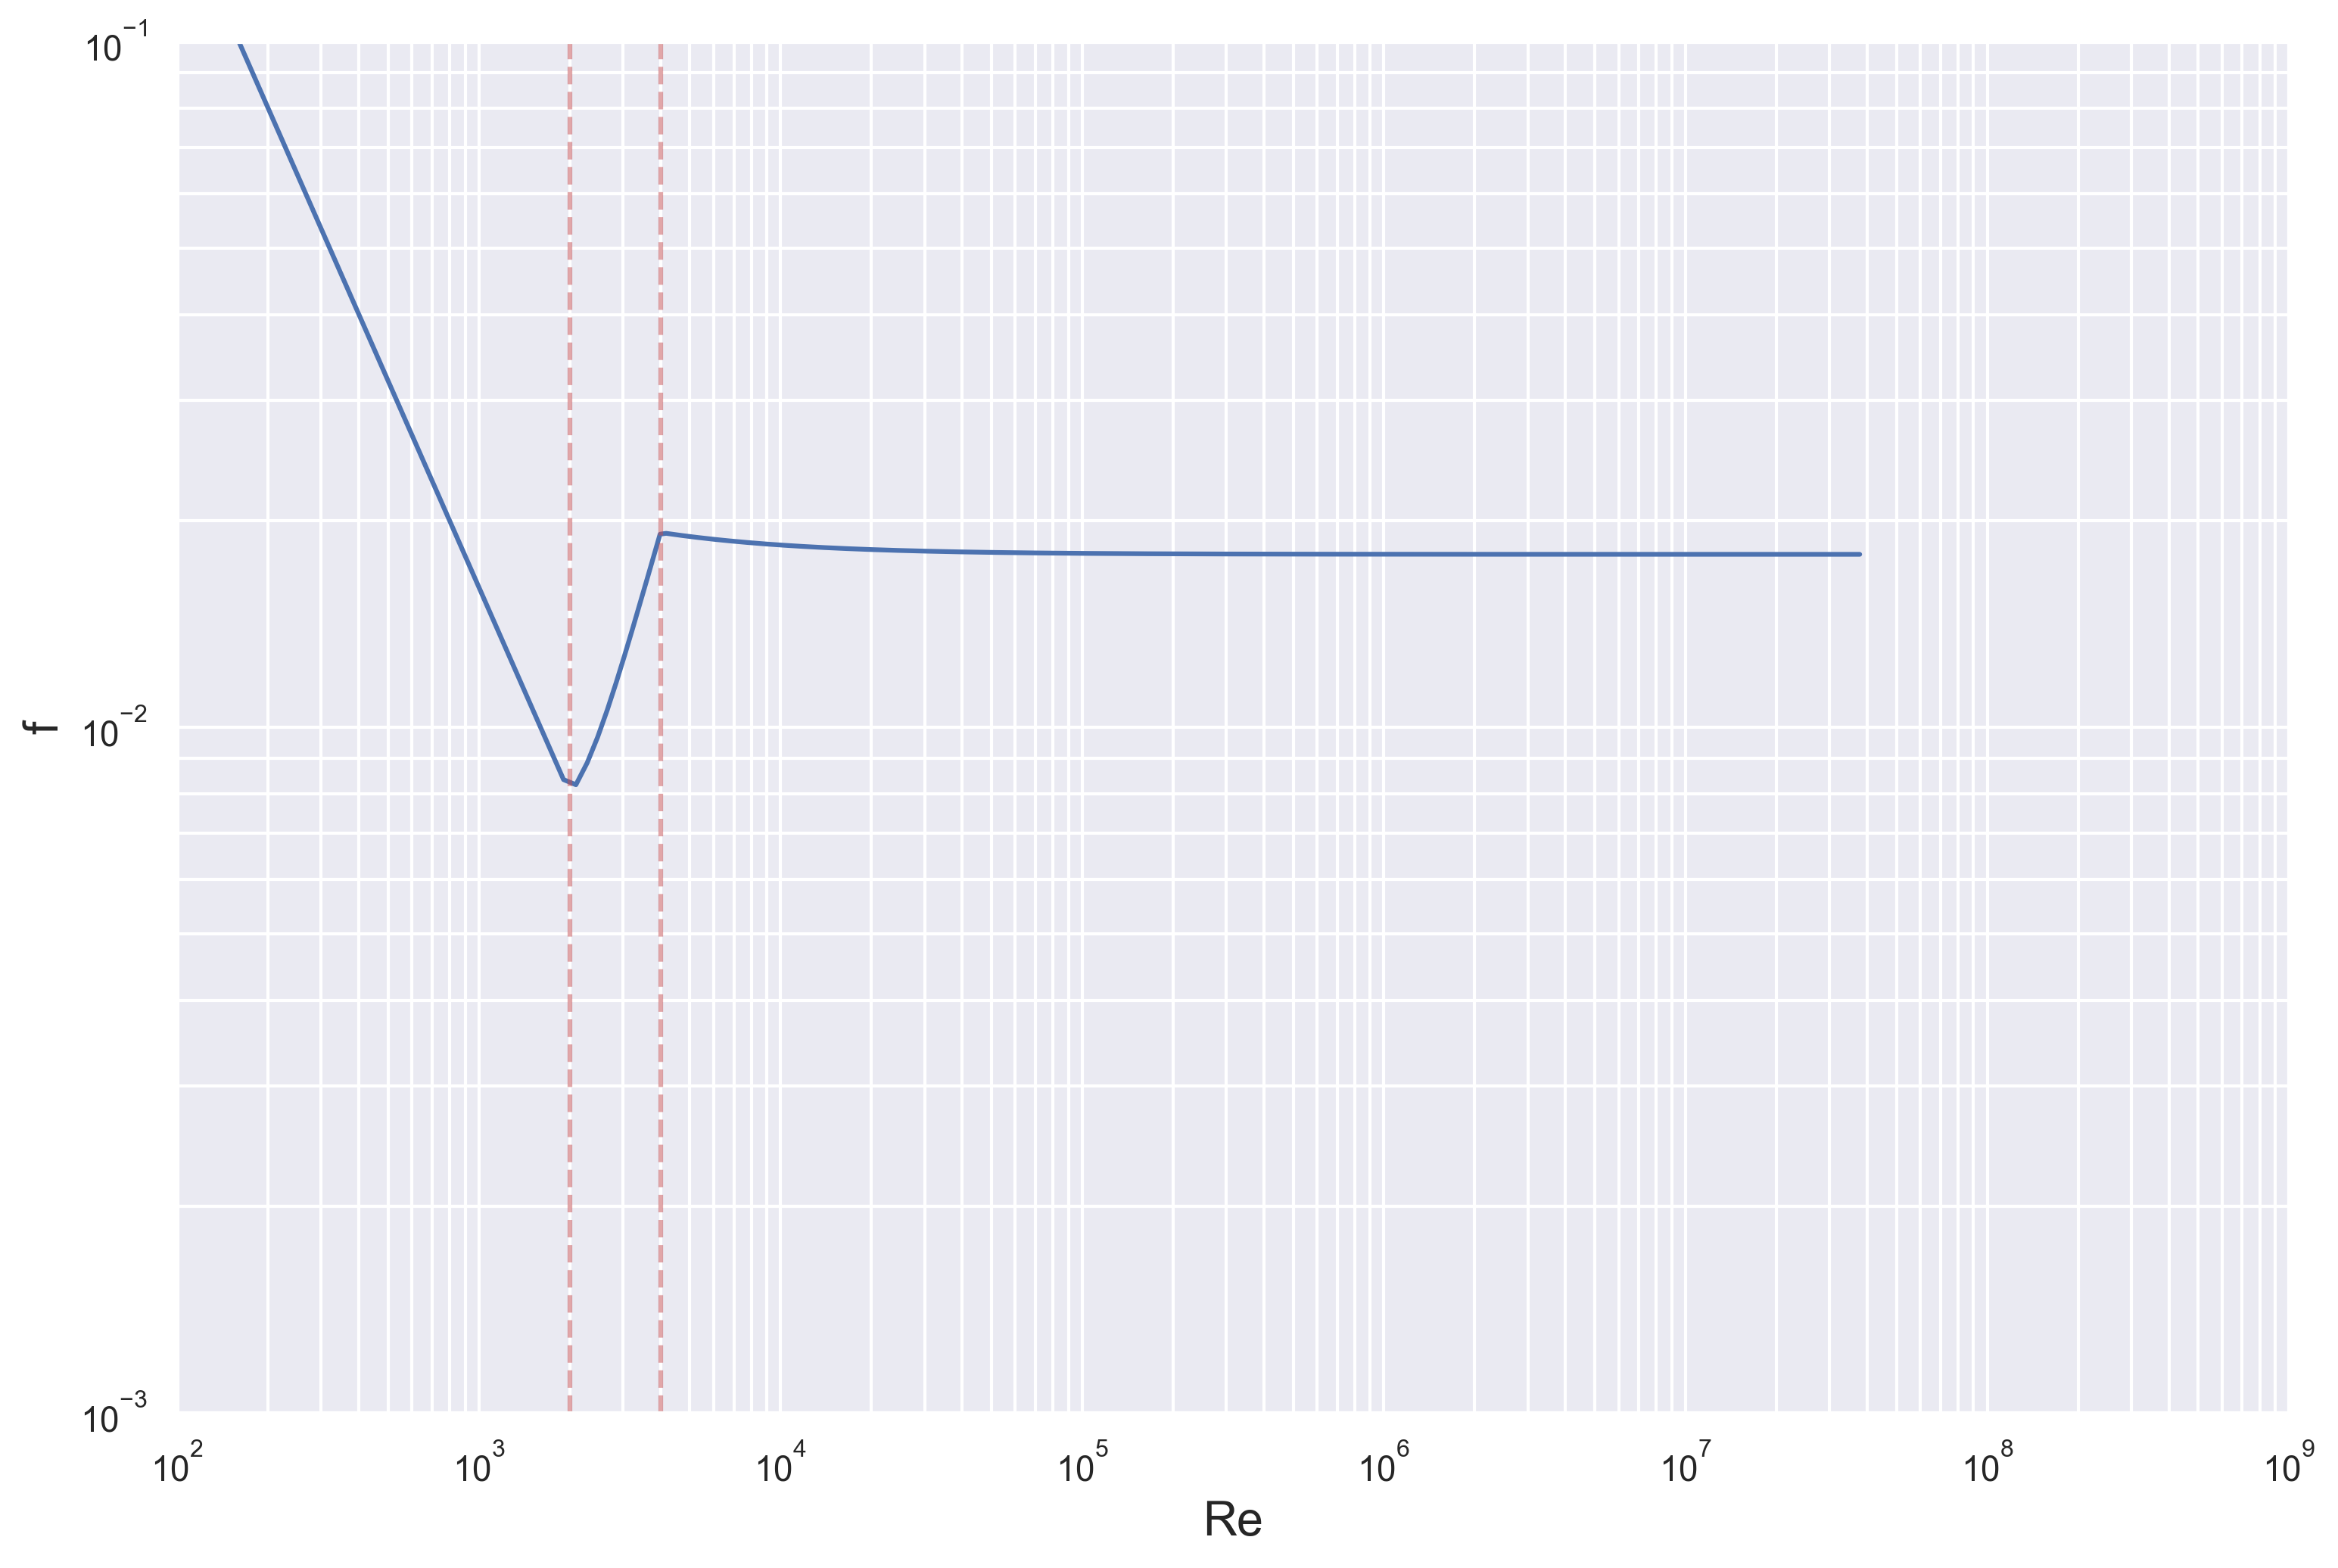

In [52]:
df.plot(x='Re', y='f', figsize=(12,8), legend=False)
plt.yscale('log')
plt.xscale('log')
plt.xlim(100, 1e9)
plt.ylim(.001, .1)
plt.xlabel('Re', fontsize=15)
plt.ylabel('f', fontsize=15)
plt.axvline(2000, ls='--', alpha=.5, c='r')
plt.axvline(4000, ls='--', alpha=.5, c='r')
plt.grid(True, which='both')

## single-phase pressure loss

### due to friction:

In [67]:
def dP_f(f, dens, vel, L, ID):
    '''
    This function imputes a Fanning friction factor, density,
    velocity, flow length, and flow area diameter, and returns
    a pressure loss due to friction.
    ...
    Arguments
    --------
    f    : Fanning friction factor,  dimensionless
    dens : fluid density,            lbm/ft3
    vel  : fluid velocity,           ft/s
    L    : flow length,              ft
    ID   : diameter of flow area,    ft
    ...
    '''
    dP_f = 2 * f * dens * vel**2 * L / (144 * 32.174 * ID)
    return dP_f

In [68]:
L = 10000

dP_f(fanning_f(re_num(dens, vel, ID, visc), .000006, ID), dens, vel, L, ID)

60.9543846135651

### due to hydrostatic:

In [79]:
def dP_h(dens, L, angle):
    
    dP_h = dens * L * np.cos(angle * 180 / np.pi) / 144
    return dP_h
    
    

In [80]:
# test the hydrostatic function:

dP_h(dens, L, 0)

4333.333333333333